In [1]:
"""
build_robust_feasibility_mask.py

Evaluates robust injection feasibility across the full 60×60 grid using
a saturation-based leakage criterion. Each cell is tested using the GRU
surrogate over NUM_MEDOIDS_USED permeability–porosity scenarios. A cell
is deemed robust-feasible if no lateral boundary leakage occurs in at
least 80% of the scenarios. Outputs include both the raw binary mask and
a Gaussian-smoothed version for visualization.

Outputs:
- robust_feasible_map_3d.npy                    (binary mask)
- robust_feasible_map_3d_gaussian_smoothed.npy (smoothed)

Corresponds to Section 3.3 and Figure 5 of the manuscript.
"""

###############################################################################
# SECTION 1 ─ Imports & static paths
###############################################################################
import os, sys
import numpy as np
import h5py
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
import gym
from gym import spaces

from surrogate_model_gru import SurrogateModel   # saturation GRU only

# ---------- file locations ---------------------------------------------------
TRAIN_DATA_H5  = "train_data.h5"
BULK_VOLUME_H5 = "BulkVolume.h5"
SAT_WEIGHTS    = "./weights/epoch_49_820_15_5_sat.pth"

###############################################################################
# SECTION 2 ─ Pick the medoids to run (speed knob)
###############################################################################
NUM_MEDOIDS_USED = 20

try:
    train_indices = np.load("train_indices.npy")
    assert train_indices.shape == (NUM_MEDOIDS_USED,)
except (FileNotFoundError, AssertionError):
    with h5py.File(TRAIN_DATA_H5, "r") as f:
        n_available = f["inputs"]["Perm"].shape[0]
    if n_available < NUM_MEDOIDS_USED:
        raise RuntimeError(f"Only {n_available} realisations in HDF5.")
    train_indices = np.arange(NUM_MEDOIDS_USED, dtype=int)
    np.save("train_indices.npy", train_indices)
    print("train_indices.npy reconstructed:", train_indices)

###############################################################################
# SECTION 3 ─ CO₂-storage environment (GPU-friendly, single call per run)
###############################################################################
class CO2StorageEnv(gym.Env):
    """Single-well CO₂-storage surrogate with GPU tensors only."""
    def __init__(self,
                 max_time = 20,
                 data_path = TRAIN_DATA_H5,
                 bulk_path = BULK_VOLUME_H5,
                 device = None):
        super().__init__()
        self.max_time        = max_time
        self.injection_until = 14
        self.device = device or torch.device("cuda" if torch.cuda.is_available()
                                             else "cpu")
        print(">>> using device:", self.device)

        self.sat_model = SurrogateModel(model_path      = SAT_WEIGHTS,
                                        model_type      = "sat",
                                        device          = self.device,
                                        normalizer_path = None)

        with h5py.File(data_path, "r") as f:
            self.perm_data = f["inputs"]["Perm"][:]   # (20,1,1,24,60,60)
            self.por_data  = f["inputs"]["Por"][:]
        with h5py.File(bulk_path, "r") as f:
            self.bulk_vol = f["BulkVol"][0, 0].astype(np.float32)

        self.num_samples = self.perm_data.shape[0]
        self.nz, self.nx, self.ny = 24, 60, 60
        self.bhp = 48_000

    # ---- utility -------------------------------------------------------------
    def make_input_tensor(self, sample_idx, well_xy, rate):
        perm = torch.from_numpy(
            self.perm_data[sample_idx,0,0].astype(np.float32)
        ).to(self.device).unsqueeze(0).unsqueeze(0)
        por  = torch.from_numpy(
            self.por_data[sample_idx,0,0].astype(np.float32)
        ).to(self.device).unsqueeze(0).unsqueeze(0)

        full = torch.zeros((1, self.max_time, 5, self.nz, self.nx, self.ny),
                           dtype=torch.float32, device=self.device)
        full[:, :, 0] = perm
        full[:, :, 1] = por
        full[:, :, 3] = self.bhp*1e-5
        full[:, :, 4] = 1.0

        if well_xy is not None:
            x, y = well_xy
            q = 0.5 + 1.5*rate
            full[0, 1:self.injection_until+1, 2, :, x, y] = q  # t=1…14

        return full

###############################################################################
# SECTION 4 ─ Robust-feasible map over *all* 60×60 cells
###############################################################################
SAT_THRESHOLD = 0.05
BOUND_PAD     = 2
AGREE_FRAC    = 0.80
SMOOTH_SIGMA  = 1.0
NX = NY = 60
INJ_RATE_NORM = (1.0 - 0.5) / 1.5   # → physical 1 Mt yr⁻¹ at rate = 1

def boundary_ok(sat3d, thr=SAT_THRESHOLD, pad=BOUND_PAD):
    s = sat3d[:, :,  :pad].max(axis=(1,2))
    n = sat3d[:, :, -pad:].max(axis=(1,2))
    w = sat3d[:,  :pad, :].max(axis=(1,2))
    e = sat3d[:, -pad:, :].max(axis=(1,2))
    return (s<=thr)&(n<=thr)&(w<=thr)&(e<=thr)

# ---------- NEW: evaluate every cell in the field ---------------------------
candidate_xy = [(x, y) for x in range(NX) for y in range(NY)]

need_ok      = int(np.ceil(AGREE_FRAC * len(train_indices)))   # 4 of 5
env          = CO2StorageEnv()
nz           = env.nz
feasible_cnt = np.zeros((nz, NX, NY), np.uint8)

# main loop -------------------------------------------------------------------
for rep in tqdm(train_indices, desc="medoids", ncols=80):
    for x, y in candidate_xy:
        full_in = env.make_input_tensor(rep, (x, y), INJ_RATE_NORM)

        with torch.no_grad():
            sat = env.sat_model.inference(full_in)      # (1,T,1,nz,nx,ny)

        sat_final = sat[0, -1, 0].cpu().numpy()         # last time slice
        feasible_cnt[:, x, y] += boundary_ok(sat_final)

# vote & save -----------------------------------------------------------------
robust = feasible_cnt >= need_ok
np.save("robust_feasible_map_3d.npy", robust)
print("✔  robust_feasible_map_3d.npy written")

fp = np.ones((3,3), bool)
robust_clean = np.empty_like(robust)
for k in range(nz):
    slice_ = binary_closing(robust[k], fp)
    slice_ = binary_opening(slice_, fp)
    robust_clean[k] = slice_
blurred  = gaussian_filter(robust_clean.astype(float), sigma=SMOOTH_SIGMA)
robust_s = blurred >= 0.5
np.save("robust_feasible_map_3d_gaussian_smoothed.npy", robust_s)
print("✔  robust_feasible_map_3d_gaussian_smoothed.npy written")



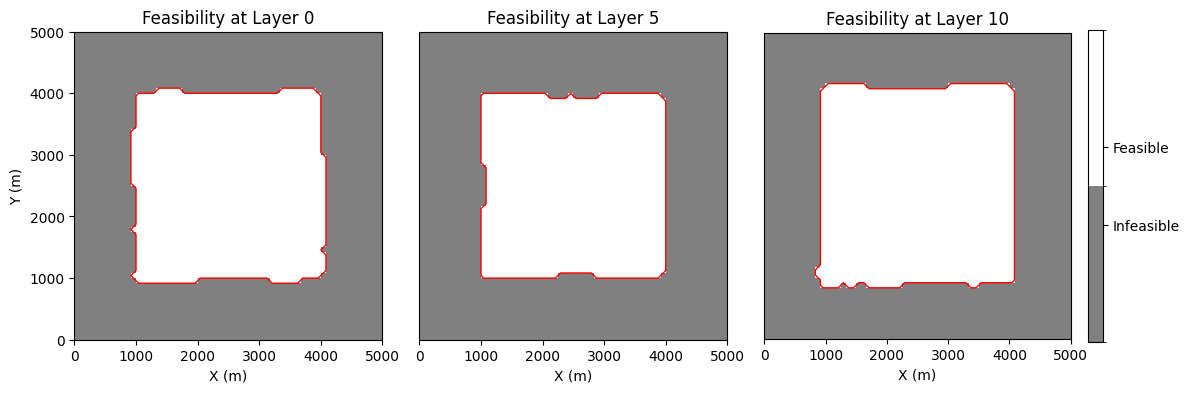

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec

# -------------------------------------------------
# 1) Load the feasibility map (shape = (nz, ny, nx))
#    This is a 3D boolean array:
#    feasible_map[z, y, x] = True/False
# -------------------------------------------------
feasible_map = np.load("robust_feasible_map_3d_gaussian_smoothed.npy")  # e.g. shape = (24, 60, 60)

# -------------------------------------------------
# 2) Set up field/grid parameters and layers
# -------------------------------------------------
grid_size = 60
field_size_m = 5000  # e.g., 5000 meters across
scale = field_size_m / grid_size  # size of each cell in meters

# Choose layers to visualize:
layers_to_plot = [0, 5, 10]  

# -------------------------------------------------
# 3) Create a discrete colormap: 0 -> gray, 1 -> white
# -------------------------------------------------
cmap = mcolors.ListedColormap(["gray", "white"])
# We set boundaries so that any 0 maps to gray, and any 1 maps to white:
bounds = [-0.5, 0.5, 1.5]  
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# -------------------------------------------------
# 4) Set up the figure and subplots
# -------------------------------------------------
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.1])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

# -------------------------------------------------
# 5) Plot each requested layer with boundary outlines
# -------------------------------------------------
for i, (ax, layer_idx) in enumerate(zip(axes, layers_to_plot)):
    # Convert the boolean layer to integer: True=1, False=0
    layer_2d = feasible_map[layer_idx].astype(int)

    # Plot the feasibility map
    im = ax.imshow(
        layer_2d,
        origin='lower',
        cmap=cmap,
        norm=norm,
        extent=[0, field_size_m, 0, field_size_m],  # so axes show real distance in meters
    )

    # Draw a contour around feasible regions (level=0.5 between 0 and 1)
    ax.contour(
        layer_2d,
        levels=[0.5],
        colors='red',
        linewidths=1,
        origin='lower',
        extent=[0, field_size_m, 0, field_size_m]
    )

    # Annotate axes
    ax.set_title(f'Feasibility at Layer {layer_idx}')
    ax.set_xlabel("X (m)")
    if i == 0:
        ax.set_ylabel("Y (m)")
    else:
        ax.set_yticks([])  # hide ticks for clarity on non-primary plots

    # For the last subplot, add a discrete colorbar
    if i == 2:
        cbar = fig.colorbar(
            im, 
            ax=ax, 
            fraction=0.046, 
            ticks=[0.25, 0.75]  # ticks between discrete segments
        )
        cbar.ax.set_yticklabels(["Infeasible", "Feasible"])

# -------------------------------------------------
# 6) Finalize and show plot
# -------------------------------------------------
plt.tight_layout()
plt.show()


C:\Users\erdogane\AppData\Local\Temp\ipykernel_7104\2942243578.py:94: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


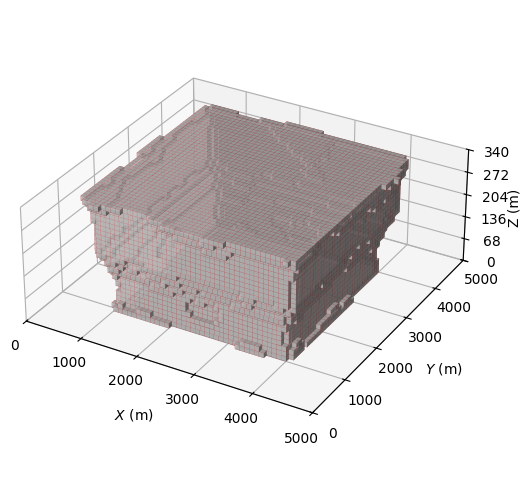

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 – activates 3-D

# ─────────────────────────────────────────────────────────
# 1) Load the Boolean feasibility cube
# ─────────────────────────────────────────────────────────
feasible_map = np.load("robust_feasible_map_3d_gaussian_smoothed.npy")  # (nz, ny, nx)
nz, ny, nx = feasible_map.shape
mask = feasible_map.astype(bool).transpose(2, 1, 0)  # (nx, ny, nz) for ax.voxels

# ─────────────────────────────────────────────────────────
# 2) Physical and visual grid parameters
# ─────────────────────────────────────────────────────────
FIELD_XY       = 5_000.0      # real field extent in X and Y  [m]
REAL_DEPTH_M   = 340.0        # actual stratigraphic thickness [m]
VISUAL_DEPTH_M = 2_000.0      # stretched depth for plotting  [m]

dx = FIELD_XY       / nx      # ≈ 83.33 m
dy = FIELD_XY       / ny
dz = VISUAL_DEPTH_M / nz      # ≈ 83.33 m, gives full 2 000 m box

# ─────────────────────────────────────────────────────────
# 3) Build voxel-corner coordinates
# ─────────────────────────────────────────────────────────
i, j, k = np.indices((nx + 1, ny + 1, nz + 1), dtype=float)
x = i * dx
y = j * dy
z = k * dz

# ─────────────────────────────────────────────────────────
# 4) Face colours
# ─────────────────────────────────────────────────────────
colors = np.empty(mask.shape + (4,), float)

# very light gray, almost transparent
colors[mask] = [0.8, 0.8, 0.8, 0.8]

# darker gray, a bit more opaque
colors[~mask] = [0.9, 0.9, 0.9, 0.6]


# ─────────────────────────────────────────────────────────
# 5) 3-D voxel plot
# ─────────────────────────────────────────────────────────
fig = plt.figure(figsize=(7, 6))
ax  = fig.add_subplot(111, projection='3d')

ax.voxels(
    x, y, z,
    mask,
    facecolors=colors,
    edgecolors='red',
    linewidth=0.05
)

# ─────────────────────────────────────────────────────────
# 6) Axis limits, ticks, and labels
# ─────────────────────────────────────────────────────────
ax.set_xlim(0, FIELD_XY)
ax.set_ylim(0, FIELD_XY)
ax.set_zlim(0, VISUAL_DEPTH_M)
ax.set_box_aspect((FIELD_XY, FIELD_XY, VISUAL_DEPTH_M))

n_ticks = 6
z_tick_pos = np.linspace(0, VISUAL_DEPTH_M, n_ticks)
z_tick_lab = np.linspace(0, REAL_DEPTH_M,   n_ticks).astype(int)

ax.set_xticks(np.linspace(0, FIELD_XY, n_ticks))
ax.set_yticks(np.linspace(0, FIELD_XY, n_ticks))
ax.set_zticks(z_tick_pos)
ax.set_zticklabels([f"{v:,}" for v in z_tick_lab])

for axis in ('x', 'y', 'z'):
    ax.tick_params(axis=axis, direction='in')

# ─────────────────────────────────────────────────────────
# 7) Styled X, Y, Z labels and title
# ─────────────────────────────────────────────────────────
ax.set_xlabel(r'$X\ (\mathrm{m})$', labelpad=10)
ax.xaxis.set_rotate_label(False)

ax.set_ylabel(r'$Y\ (\mathrm{m})$', labelpad=10)
ax.yaxis.set_rotate_label(False)

# place Z label inside the right side of the cube
fig.text(
    0.90, 0.55, 'Z (m)',
    va='center', ha='center',
    rotation='vertical',
    fontsize=plt.rcParams['axes.labelsize']
)

plt.tight_layout()
plt.savefig("Figures/Fig51.png", transparent=True, bbox_inches="tight", dpi=600)
plt.show()


C:\Users\erdogane\AppData\Local\Temp\ipykernel_7104\1138839190.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


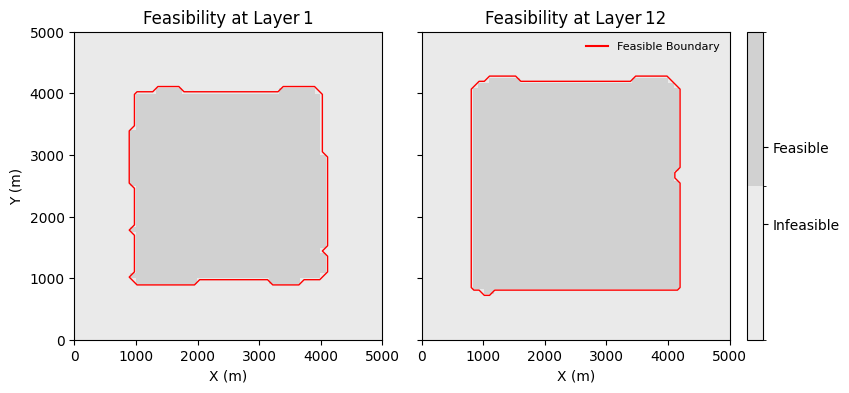

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec

# -------------------------------------------------
# 1) Load the feasibility map  (nz, ny, nx) = (24, 60, 60)
# -------------------------------------------------
feasible_map = np.load("robust_feasible_map_3d_gaussian_smoothed.npy")

# -------------------------------------------------
# 2) Field/grid parameters
# -------------------------------------------------
grid_size    = feasible_map.shape[-1]        # 60
field_size_m = 5000                          # metres across
layers_to_plot = [0, 11]                     # layer indices 0 and 11
x = np.linspace(0, field_size_m, grid_size)  # coordinate vectors
y = np.linspace(0, field_size_m, grid_size)
X, Y = np.meshgrid(x, y)

# -------------------------------------------------
# 3) Two‑class RGBA colormap   (0 = infeasible, 1 = feasible)
# -------------------------------------------------

cmap = mcolors.ListedColormap([
    (0.90, 0.90, 0.90, 0.8),   # light grey — infeasible
    (0.80, 0.80, 0.80, 0.9)    # dark grey — feasible
])

bounds = [-0.5, 0.5, 1.5]
norm   = mcolors.BoundaryNorm(bounds, cmap.N)

# -------------------------------------------------
# 4) Figure & axes
# -------------------------------------------------
fig = plt.figure(figsize=(9, 4))
gs  = gridspec.GridSpec(1, 2, width_ratios=[1, 1.1], wspace=0.05)
axes = [fig.add_subplot(gs[i]) for i in range(2)]

# -------------------------------------------------
# 5) Plot requested layers
# -------------------------------------------------
for i, (ax, layer_idx) in enumerate(zip(axes, layers_to_plot)):
    layer_int = feasible_map[layer_idx].astype(int)

    # image
    im = ax.imshow(
        layer_int,
        origin="lower",
        cmap=cmap,
        norm=norm,
        extent=[0, field_size_m, 0, field_size_m]
    )

    # red outline of the feasible envelope
    ax.contour(
        X, Y, layer_int,
        levels=[0.5],
        colors="red",
        linewidths=1
    )

    # labels, ticks, aspect
    ax.set_title(f"Feasibility at Layer {layer_idx + 1}")
    ax.set_xlabel("X (m)")
    if i == 0:
        ax.set_ylabel("Y (m)")
    else:
        ax.set_yticklabels([])
    ax.set_aspect("equal")

    # add discrete legend patch once (right panel)
    if i == 1:
        # dummy handle so legend shows a red line
        ax.plot([], [], color="red", label="Feasible Boundary")
        ax.legend(loc="upper right", frameon=False, fontsize=8)

        # colour‑bar
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, ticks=[0.25, 0.75])
        cbar.ax.set_yticklabels(["Infeasible", "Feasible"])

# -------------------------------------------------
plt.tight_layout()
plt.savefig("Figures/Fig52.png", transparent=True, bbox_inches="tight", dpi=600)
plt.show()
